# Assignment 1

In [112]:
from pynq.overlays.base import BaseOverlay
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import time
from datetime import datetime
base = BaseOverlay("base.bit")

In [113]:
%%microblaze base.PMODB

#include "gpio.h"
#include "pyprintf.h"

//Function to turn on/off a selected pin of PMODB
void write_gpio(unsigned int pin, unsigned int val){
    if (val > 1){
        pyprintf("pin value must be 0 or 1");
    }
    gpio pin_out = gpio_open(pin);
    gpio_set_direction(pin_out, GPIO_OUT);
    gpio_write(pin_out, val);
}

//Function to read the value of a selected pin of PMODB
unsigned int read_gpio(unsigned int pin){
    gpio pin_in = gpio_open(pin);
    gpio_set_direction(pin_in, GPIO_IN);
    return gpio_read(pin_in);
}

//Fuction to reset all GPIO pins on PMODB
void reset_pins(){
    int i;
    for(i = 0; i <8; i++){
        write_gpio(i,0);
    }
}

In [99]:
write_gpio(6,1)

In [88]:
reset_pins()

## PWM with Python3

In [37]:
#Function to emulate PWM. frequency is in Hz and duty_cycle is percentage
def my_PWM(frequency, duty_cycle):
    timePeriod = 1/frequency

    while True:
        if duty_cycle == 0: #corner case for duty cycle 0%
            write_gpio(5,0)
        elif duty_cycle == 100: #corner case for duty cycle 100%
            write_gpio(5,1)
        else:
            onTime = (duty_cycle/100)*timePeriod;
            offTime = timePeriod - onTime;
            write_gpio(5,1)
            time.sleep(onTime)
           # print(onTime)
            reset_pins()
            time.sleep(offTime)
           # print(offTime)
    

In [115]:
reset_pins()

In [40]:
my_PWM(50,50)

KeyboardInterrupt: 

### Report:
To emulate PWM, my thought process was to design an infinite loop that would turn an LED on and off continuously.  I made use of the previous code where we write to gpio and set the pin to 1 in order to turn on the LED. Then I reset the pin to 0 in order to achieve the time "off." I determined that the time period would be 1/frequency and calculated duty cycle as a percentage of the time period.  By varying the frequency, I found that the Optimal PWM frequency was around 50Hz.  The physical flashing was no longer perceivable to my eye.  Alternatively, changing the duty cycle value affected the LED perceived brightness.  Specifically, to my eye the brightness around 10% duty cycle looked like it was at 25% bright.  At 30% duty cycle, I perceived 50% brightness.  At 50% duty cycle, I perceived 75% brightness.  And any duty cycle of 60% or higher looked 100% brightness to me.

## Perceived LED Brightness Plot

The plot below shows the different duty cycles at which my eye perceived the different brightness percantages.

Text(0, 0.5, 'perceived brightness')

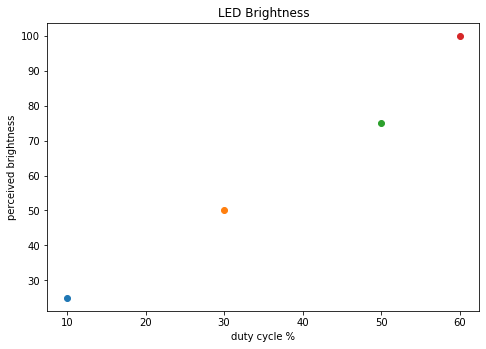

In [8]:
from matplotlib import pyplot as plot
import numpy as num
import math
%matplotlib inline
fig = plot.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(10,25,marker = 'o')
ax.plot(30,50,marker = 'o')
ax.plot(50,75,marker = 'o')
ax.plot(60,100,marker = 'o')
ax.set_title('LED Brightness')
ax.set_xlabel('duty cycle %')
ax.set_ylabel('perceived brightness')

### Trouble Encountered
An issue I encountered with this part of the assignment was that sometimes interrupting the code by pressing the STOP button, the LED would become unresponsive.  A workaround that worked for me was reloading the Overlay and MicroBlaze code.  This would reset the board/LED and I could continue testing my code.  I also tried adding print statements to help walk through my code and debug, but my code worked as expected until I interrupted the code too many times.

## PWM using ASYNCIO

In [ ]:
import asyncio
reset_pins() #start with all pins set to 0
btns = base.btns_gpio #define buttons
cond = True #set initial condition to true
flag = 0 # set flag to zero to start loop with the red LED blinking

async def async_PWM(frequency):
    global flag, cond, start
    timePeriod = 1/frequency #calculate time period
    timeOn = timePeriod/2 #determine time on wait
    timeOff = timePeriod - timeOn #determine time off wait
    while cond: # we want to continously run the code for an embedded system
        #print(flag)
        if flag == 0: # if flag value is 0, this is initial state and we want blink red LED
            write_gpio(7,1)
            await asyncio.sleep(timeOn)
            write_gpio(7,0)
            await asyncio.sleep(timeOff)
        elif flag == 1: # if flag value is 1, button 0, 1, or 2 has been pressed, so we blink all 3 LED colors
            write_gpio(7,1)
            await asyncio.sleep(timeOn)
            write_gpio(7,0)
            await asyncio.sleep(timeOff)
            write_gpio(6,1)
            await asyncio.sleep(timeOn)
            write_gpio(6,0)
            await asyncio.sleep(timeOff)
            write_gpio(5,1)
            await asyncio.sleep(timeOn)
            write_gpio(5,0)
            await asyncio.sleep(timeOff)
        elif flag == 2: # if flag value is 2, button 3 has been pressed, so we want to stop blinking
            write_gpio(7,0)
            write_gpio(6,0)
            write_gpio(5,0)
            await asyncio.sleep(timePeriod)

async def get_btns(_loop):
    global flag, cond, start
    while cond:
        await asyncio.sleep(0.01)
        if base.buttons[0].read() != 0: #if button 0 was pressed, set flag to 1
            flag = 1                     
        elif base.buttons[1].read() != 0: #if button 1 was pressed, set flag to 1
            flag = 1
        elif base.buttons[2].read() != 0: #if button 2 was pressed, set flag to 1
            flag = 1
        elif base.buttons[3].read() != 0: #if button 3 was pressed, set flag to 1
            flag = 2
            

loop = asyncio.new_event_loop() #define loop
loop.create_task(async_PWM(.5)) # create PWM task to loop, and set PWM frequency to .5hz
loop.create_task(get_btns(loop)) # create button reader task to loop
loop.run_forever() #run loop infinitely


<Task pending name='Task-81' coro=<async_PWM() running at <ipython-input-116-e19073f331dc>:7>>

<Task pending name='Task-82' coro=<get_btns() running at <ipython-input-116-e19073f331dc>:38>>

### Conclusion
For the async PWM part of this assignment, I first worked on the starting state which was blinking the red LED.  Then I  made sure it was working with the task that read from the buttons.  Once I got that working, I thought of the best way to design the remaining functionalities which was transitioning between states based on button input.  I decided to use a flag that would help map which state I would transition to, depending on the button pushed.  There are 3 main states: red LED blink state, red blue green LEDs blink state, and no LED blink state.  These states were determined by flag values 0, 1, 2 depending on what button is pressed.  Once I got all 3 states coded, I noticed my LED would get stuck on the no blink state.  I realized I didnt have the asyncio.sleep wait, which would sync the two tasks.  To test that the different states were working, I added a print command that would output the value of the flag.  This let me know which state I was in. I tested 2 states first and then all 3 states.   